In [4]:
import numpy as np
import sympy as sp
from sympy import Symbol
from sympy import solve, Poly, Eq, Function, exp
import math
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks
import os
import imp
import matplotlib.pyplot as plt
import sys
os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 

#linux
#sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
#import lumapi
#sys.path.append(os.path.dirname('/home/moises/Downloads/'))

## Theorical Values

In [66]:
def bandwidth(wavelength, response, number_of_points):
    ##number_of_points = Number_of_iteration/2
    max_index = 0
    min_index = 0
    for i in range(number_of_points):
        if response[number_of_points - i]>0.01 and response[number_of_points - (i+1)] < 0.01: ##-30 dB
            min_index = number_of_points - i
            break
        
    for j in range(number_of_points):
        if response[number_of_points + j]>0.01 and response[number_of_points + (j+1)] < 0.01: ##-330 dB
            max_index = number_of_points + j
            break

    return wavelength[min_index], wavelength[max_index]


In [57]:
def FWHM(wavelength, response, number_of_points):
    ##number_of_points = Number_of_iteration/2
    for i in range(number_of_points):
        if 10*np.log10(response[number_of_points - i])> - 3 and 10*np.log10(response[number_of_points - (i+1)]) < -3: ##-3 dB
            min_index = number_of_points - i
            break
        
    for j in range(number_of_points):
        if 10*np.log10(response[number_of_points + j])>-3 and 10*np.log10(response[number_of_points + (j+1)]) < -3: ##-3 dB
            max_index = number_of_points + j
            break

    return wavelength[min_index], wavelength[max_index]

In [3]:
mode = lumapi.MODE(filename= 'Bragg.lms')

In [6]:
pi = np.pi
lambda_b = 1560e-9
neff = 2.257333
ng = 4.606854
bandwidth = 20e-9
w = 0.45e-6
delta_w = 0.05e-6
period = lambda_b/(2*neff)
N = 150
L = N*period
kappa = np.sqrt(bandwidth**2*pi**2*ng**2/lambda_b**4 - (pi/L)**2)
r_max = np.tanh(kappa*L)
delta_n = kappa*lambda_b/2
a_c = kappa*lambda_b/(np.pi) ## AC part of the induced index
print(period)
print(L)
print(kappa)
print(r_max)
print(delta_n)
print(a_c)

3.455405117454979e-07
5.1831076761824686e-05
102339.43455321377
0.9999506021518704
0.07982475895150674
0.05081801987300528


In [170]:
mode.switchtolayout()
mode.deleteall()

mode.addrect()
mode.set({"name":"guide1",
"x":0,
"x span":period/2,
"y":0,
"y span":w + delta_w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})

mode.addrect()
mode.set({"name":"guide2",
"x":period/4 + period/4,
"x span":period/2,
"y":0,
"y span":w - delta_w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})


mode.addrect()
mode.set({"name":"guide_before",
"x max":-period/4,
"x min":-period/4-0.5e-6,
"y":0,
"y span":w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})

mode.addrect()
mode.set({"name":"guide_after",
"x max":period/4 + period/4 + period/4 + 0.5e-6,
"x min":period/4 + period/4 + period/4,
"y":0,
"y span":w,
"z":0,
"z span":0.22e-6,
"material":'Si (Silicon) - Palik'})

mode.addrect()
mode.set({"name":"substrato",
"x":0,
"x span":2e-6,
"y":0,
"y span":2e-6,
"z min":-2.11e-6})
mode.setnamed("substrato","z min",-2.11e-6)
mode.setnamed("substrato","z max",-0.11e-6)
mode.setnamed("substrato","material","SiO2 (Glass) - Palik")

In [171]:
mode.switchtolayout()
mode.select("FDE")
mode.delete()
mode.select("mesh")
mode.delete()
mode.addfde()
mode.setnamed("FDE","solver type","2D X normal")
mode.set({"x":0,
"y":0,
"y span":3e-6,
"z":0,
"z span":3e-6,
"mesh cells y":250,
"mesh cells z":250})

mode.addmesh()
mode.set({"x":0,
"x span":0.1e-6,
"y":0,
"y span":0.6e-6,
"z":0,
"z span":0.3e-6})
mode.set({"override x mesh":0,
"dy":0.005e-6,
"dz":0.005e-6})

mode.addmesh()
mode.set({"x":period/4 + period/4,
"x span":0.1e-6,
"y":0,
"y span":0.6e-6,
"z":0,
"z span":0.3e-6})
mode.set({"override x mesh":0,
"dy":0.005e-6,
"dz":0.005e-6})

{!!}



C:\Program Files\Lumerical\v202\api\python\lumapi.py:138: UserWarning: Multiple objects named '::model::mesh'. Use of this object may give unexpected results.
  warnings.warn(message)


In [173]:
number_of_points = 5
neff_1 = np.zeros(number_of_points)
neff_2 = np.zeros(number_of_points)
dw = np.linspace(0, 0.08e-6, number_of_points)
for i in range(len(dw)):
    mode.switchtolayout()
    mode.setnamed("FDE","x",0)
    mode.setnamed("guide1","y span", w + dw[i])
    mode.findmodes()
    neff_1[i] = np.real(mode.getdata('FDE::data::mode1','neff'))

for j in range(len(dw)):
    mode.switchtolayout()
    mode.setnamed("FDE","x",period/4 + period/4)
    mode.setnamed("guide2","y span", w - dw[j])
    mode.findmodes()
    neff_2[j] = np.real(mode.getdata('FDE::data::mode1','neff'))

In [17]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

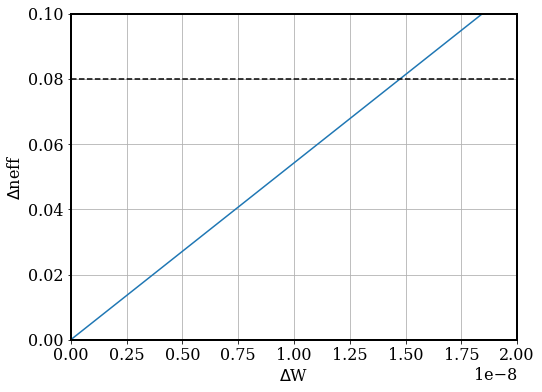

In [177]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
figure = plt.figure(figsize=(8,6))
plt.plot(dw, neff_1 - neff_2)
plt.axhline(y = delta_n, xmax = 1.5, linestyle = '--', color = "black")
plt.xlim([0, 2e-8])
plt.ylim([0, 0.1])
plt.xlabel("$\Delta$W")
plt.ylabel("$\Delta$neff")
plt.grid(True)

Text(0.5, 1.0, '$\\Delta$W = 14.7 nm')

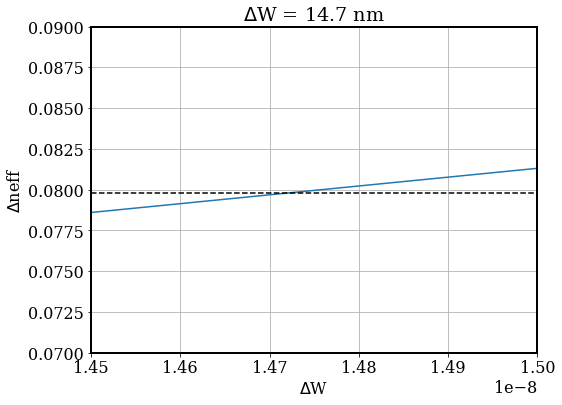

In [182]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
figure = plt.figure(figsize=(8,6))
plt.plot(dw, neff_1 - neff_2)
plt.axhline(y = delta_n, xmax = 1.5, linestyle = '--', color = "black")
plt.xlim([1.45e-8, 1.5e-8])
plt.ylim([0.07, 0.09])
plt.xlabel("$\Delta$W")
plt.ylabel("$\Delta$neff")
plt.grid(True)
plt.title("$\Delta$W = 14.7 nm")

In [183]:
delta_w = 14.7e-9
mode.switchtolayout()
mode.setnamed("guide1","y span", w + delta_w)
mode.setnamed("guide2","y span", w - delta_w)


In [184]:
mode.switchtolayout()
mode.select("EME")
mode.delete()
mode.addeme()
mode.setnamed("EME","x min",-period/4-0.25e-6)
mode.set({"y":0,
"y span":2e-6,
"z":0,
"z span":2e-6})
#mode.set("allow custom eigensolver settings",1)
mode.set("number of cell groups",4) 
mode.set("number of modes for all cell groups", 10)
mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))
mode.set({"y min bc":"PML",
"y max bc":"PML",
"z min bc":"PML",
"z max bc":"PML",
"mesh cells z":250,
"mesh cells y":250})


In [188]:
number_of_wavelength_points = 1000
mode.setemeanalysis("wavelength",1)
mode.setemeanalysis("start wavelength",lambda_b - 10e-9)
mode.setemeanalysis("stop wavelength",lambda_b + 10e-9)
mode.setemeanalysis("number of wavelength points",number_of_wavelength_points)
mode.emesweep('wavelength sweep')
response = mode.getemesweep("S_wavelength_sweep")
s_response = abs(response['s11']**2)
wavelength_response = response['wavelength']
peak = find_peaks(s_response, height=0.5)
peak_pos = wavelength_response[peak[0]]
band_nulls = bandwidth(wavelength_response,s_response,500)
bandwidth_null = band_nulls[1] - band_nulls[0]

mode.setemeanalysis("wavelength",1)
mode.setemeanalysis("start wavelength",peak_pos[0][0] - 20e-9)
mode.setemeanalysis("stop wavelength",peak_pos[0][0] + 20e-9)
mode.setemeanalysis("number of wavelength points",number_of_wavelength_points)
mode.emesweep('wavelength sweep')
S_parameters = mode.getemesweep("S_wavelength_sweep")
s11= abs(S_parameters['s11']**2)
wavelength = S_parameters['wavelength']
band = FWHM(wavelength, s11,500)
fwhm = band[1] - band[0]

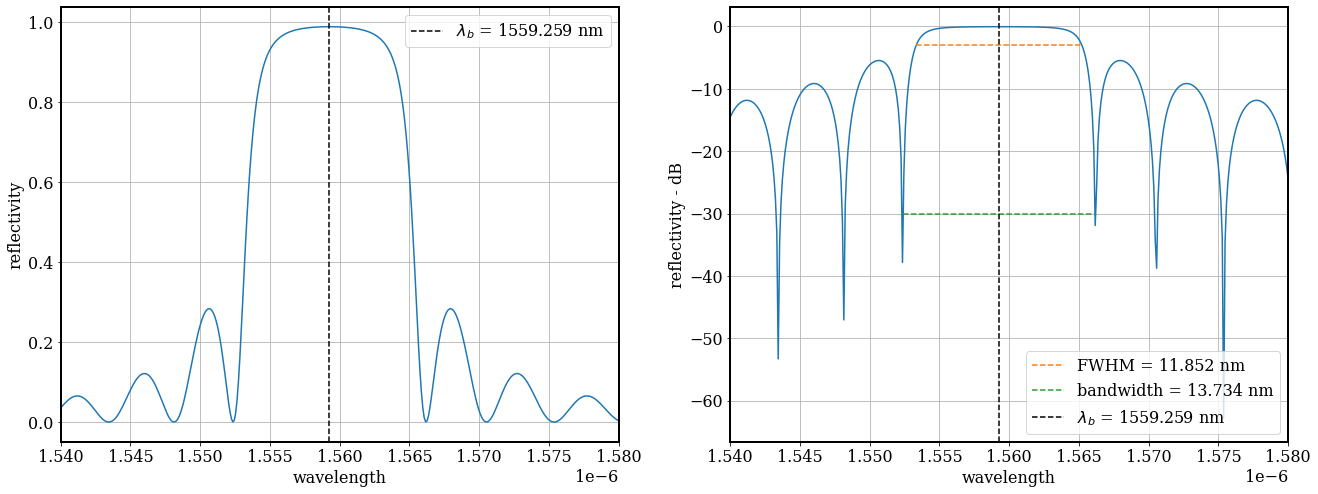

In [189]:
mode.setemeanalysis("start wavelength",1500e-9)
mode.setemeanalysis("stop wavelength",1600e-9)
mode.emesweep('wavelength sweep')
S_parameters = mode.getemesweep("S_wavelength_sweep")
s11= abs(S_parameters['s11']**2)
wavelength = S_parameters['wavelength']
peak = find_peaks(s11, height=0.5)
peak_pos = wavelength[peak[0]]

figure, ax = plt.subplots(1, 2, figsize=(22,8))

plt.rc('font', **font)
plt.rc('axes', linewidth=2)
ax[0].plot(wavelength, s11)
ax[0].axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
ax[0].set_xlim([1.54e-6, 1.58e-6])
#plt.ylim([0.07, 0.09])
ax[0].set_xlabel("wavelength")
ax[0].set_ylabel("reflectivity")
ax[0].grid(True)
ax[0].legend(loc = 'upper right')

ax[1].plot(wavelength, 10*np.log10(s11))
ax[1].plot([band[0], band[1]], [-3, -3], '--', label = "FWHM = " + str(round(fwhm[0]*1e9, 3)) + ' nm')
ax[1].plot([band_nulls[0], band_nulls[1]], [-30, -30], '--', label = "bandwidth = " + str(round(bandwidth_null[0]*1e9, 3)) + ' nm')
ax[1].axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
ax[1].set_xlim([1.54e-6, 1.58e-6])
#plt.ylim([0.07, 0.09])
ax[1].set_xlabel("wavelength")
ax[1].set_ylabel("reflectivity - dB")
ax[1].grid(True)
ax[1].legend(loc = 'lower right')

In [193]:
mode.switchtolayout()
number_of_iterations = 3
period_var = np.linspace(period - 5e-9, period + 5e-9, number_of_iterations)
lambda_brag = np.zeros(number_of_iterations)

for i in range(number_of_iterations):
    mode.switchtolayout()
    mode.setnamed("guide1","x span",period_var[i]/2)
    mode.setnamed('guide2','x',period_var[i]/4 + period_var[i]/4)
    mode.setnamed('guide2','x span',period_var[i]/2)
    mode.setnamed('guide_before','x min',-period_var[i]/4 - 0.5e-6)
    mode.setnamed('guide_before','x max',-period_var[i]/4)
    mode.setnamed('guide_after','x max',period_var[i]/4 + period_var[i]/4 + period_var[i]/4 + 0.5e-6)
    mode.setnamed('guide_after','x min',period_var[i]/4 + period_var[i]/4 + period_var[i]/4)
    mode.select('EME')
    mode.set("group spans", np.transpose([0.25e-6, period_var[i]/2,period_var[i]/2,0.25e-6]))
    mode.run()
    mode.setemeanalysis("start wavelength",1500e-9)
    mode.setemeanalysis("stop wavelength",1600e-9)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    peak = find_peaks(s11, height=0.5)
    peak_pos = wavelength[peak[0]]
    lambda_brag[i] = peak_pos[0][0]
    

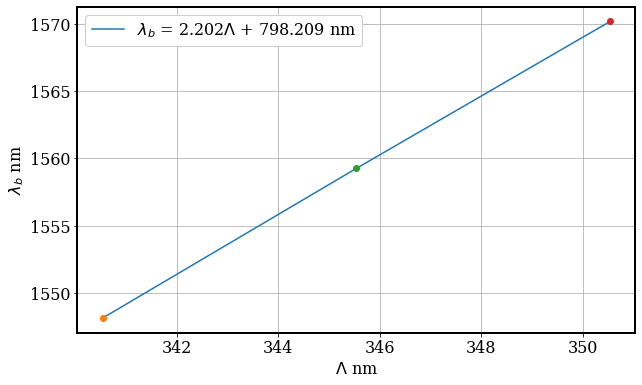

In [194]:
figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
a = (lambda_brag[2] - lambda_brag[0])/(period_var[2] - period_var[0])
b = lambda_brag[0] - a*period_var[0]
plt.plot(period_var*1e9, lambda_brag*1e9, label = '$\lambda_b$ = ' + str(round(a, 3)) + '$\Lambda$' + ' + ' + str(round(b*1e9, 3)) + ' nm')
plt.plot(period_var[0]*1e9,lambda_brag[0]*1e9, 'o')
plt.plot(period_var[1]*1e9,lambda_brag[1]*1e9, 'o')
plt.plot(period_var[2]*1e9,lambda_brag[2]*1e9, 'o')
plt.xlabel('$\Lambda$' + ' nm')
plt.ylabel('$\lambda_b$' + ' nm')
plt.grid(True)
plt.legend(loc = 'upper left', framealpha = 1)

In [192]:
mode.switchtolayout()
mode.setnamed("guide1",'x',0)
mode.setnamed('guide1','x span',period/2)
mode.setnamed('guide2','x',period/4 + period/4)
mode.setnamed('guide2','x span',period/2)
mode.setnamed('guide_before','x max',-period/4)
mode.setnamed('guide_before','x min',-period/4-0.5e-6)
mode.setnamed('guide_after','x max',period/4 + period/4 + period/4 + 0.5e-6)
mode.setnamed('guide_after','x min',period/4 + period/4 + period/4)

In [231]:
N = 5
corrugation_width = np.linspace(10e-9, 40e-9, N)
fwhm = np.zeros(N)
for i in range(N):
    mode.switchtolayout()
    mode.setnamed("guide1","y span",w + corrugation_width[i])
    mode.setnamed('guide2','y span',w - corrugation_width[i])
    mode.select('EME')
    mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))
    mode.run()
    mode.setemeanalysis("Wavelength sweep",1)
    mode.setemeanalysis("start wavelength",1500e-9)
    mode.setemeanalysis("stop wavelength",1600e-9)
    mode.setemeanalysis("number of wavelength points",1000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    peak = find_peaks(s11, height=0.7)
    peak_pos = wavelength[peak[0]]
    mode.setemeanalysis("start wavelength",peak_pos[0][0] - 20e-9)
    mode.setemeanalysis("stop wavelength",peak_pos[0][0] + 20e-9)
    mode.setemeanalysis("number of wavelength points",1000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    band = bandwidth(wavelength, s11,500)
    fwhm[i] = band[1][0] - band[0][0]

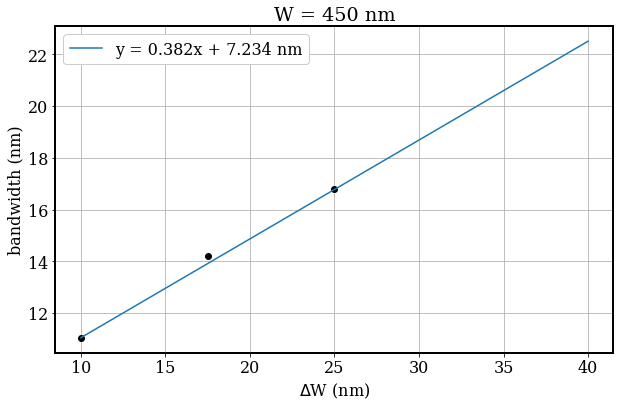

In [280]:
figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
for i in range (3):
    plt.plot(corrugation_width[i]*1e9, fwhm[i]*1e9,'o', color = 'black')

a = (fwhm[2] - fwhm[0])/(corrugation_width[2] - corrugation_width[0])
b = fwhm[2] - a*corrugation_width[2]
x = np.linspace(10e-9, 40e-9, 1000)
y = a*x + b
#plt.plot(corrugation_width, fwhm)
plt.plot(x*1e9, y*1e9,label = 'y = '+ str(round(a, 3)) + 'x + ' + str(round(b*1e9, 3)) + ' nm')
plt.xlabel('$\Delta$' + 'W (nm)')
plt.ylabel('bandwidth (nm)')
plt.grid(True)
plt.title('W = 450 nm')
plt.legend(loc = 'upper left', framealpha = 1)

In [250]:
N = 5
corrugation_width = np.linspace(10e-9, 40e-9, N)
fwhm_2 = np.zeros(N)
mode.setnamed('guide_after','y span',500e-9)
mode.setnamed('guide_before','y span',500e-9)
for i in range(N):
    mode.switchtolayout()
    mode.setnamed("guide1","y span",500e-9 + corrugation_width[i])
    mode.setnamed('guide2','y span',500e-9 - corrugation_width[i])
    mode.select('EME')
    mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))
    mode.run()
    mode.setemeanalysis("Wavelength sweep",1)
    mode.setemeanalysis("start wavelength",1500e-9)
    mode.setemeanalysis("stop wavelength",1700e-9)
    mode.setemeanalysis("number of wavelength points",2000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    peak = find_peaks(s11, height=0.7)
    peak_pos = wavelength[peak[0]]
    mode.setemeanalysis("start wavelength",peak_pos[0][0] - 20e-9)
    mode.setemeanalysis("stop wavelength",peak_pos[0][0] + 20e-9)
    mode.setemeanalysis("number of wavelength points",1000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    band = bandwidth(wavelength, s11,500)
    fwhm_2[i] = band[1][0] - band[0][0]

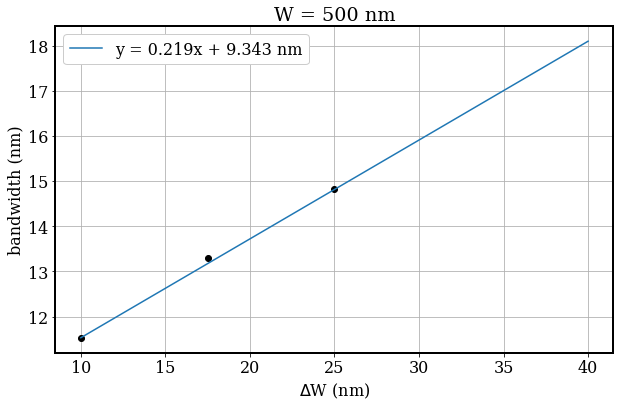

In [281]:
figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
for i in range (3):
    plt.plot(corrugation_width[i]*1e9, fwhm_2[i]*1e9,'o', color = 'black')

a2 = (fwhm_2[2] - fwhm_2[0])/(corrugation_width[2] - corrugation_width[0])
b2 = fwhm_2[2] - a2*corrugation_width[2]
x = np.linspace(10e-9, 40e-9, 1000)
y2 = a2*x + b2
#plt.plot(corrugation_width, fwhm)
plt.plot(x*1e9, y2*1e9,label = 'y = '+ str(round(a2, 3)) + 'x + ' + str(round(b2*1e9, 3)) + ' nm')
plt.xlabel('$\Delta$' + 'W (nm)')
plt.ylabel('bandwidth (nm)')
plt.grid(True)
plt.title('W = 500 nm')
plt.legend(loc = 'upper left', framealpha = 1)

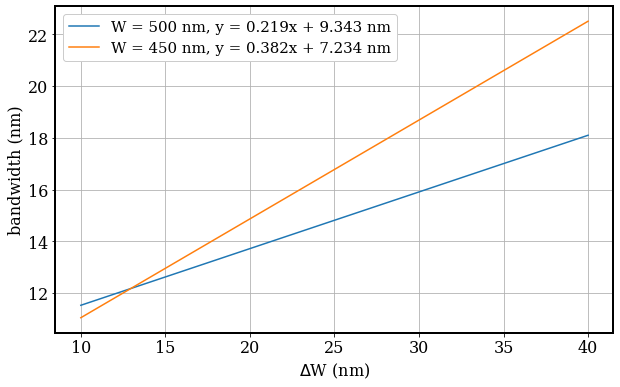

In [283]:
figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(x*1e9, y2*1e9,label = 'W = 500 nm, y = '+ str(round(a2, 3)) + 'x + ' + str(round(b2*1e9, 3)) + ' nm')
plt.plot(x*1e9, y*1e9,label = 'W = 450 nm, y = '+ str(round(a, 3)) + 'x + ' + str(round(b*1e9, 3)) + ' nm')
plt.xlabel('$\Delta$' + 'W (nm)')
plt.ylabel('bandwidth (nm)')
plt.grid(True)
plt.legend(loc = 'upper left', framealpha = 1, fontsize = 15)

In [286]:
delta_w = 14.7e-9
mode.switchtolayout()
mode.setnamed("guide1","y span", w + delta_w)
mode.setnamed("guide2","y span", w - delta_w)
mode.setnamed('guide_after','y span', w)
mode.setnamed('guide_before','y span', w)

In [9]:
mode.switchtolayout()
mode.select('EME')
mode.set('periods',np.transpose([1, 250, 1]))
#mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))

N = [150, 300, 500, 750]
s11 = np.zeros((len(N), 1000))

for i in range(len(N)):
    mode.switchtolayout()
    mode.select('EME')
    mode.set('periods',np.transpose([1, N[i], 1]))
    mode.run()
    mode.setemeanalysis("Wavelength sweep",1)
    mode.setemeanalysis("start wavelength",1500e-9)
    mode.setemeanalysis("stop wavelength",1600e-9)
    mode.setemeanalysis("number of wavelength points",1000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11[i,:]= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']

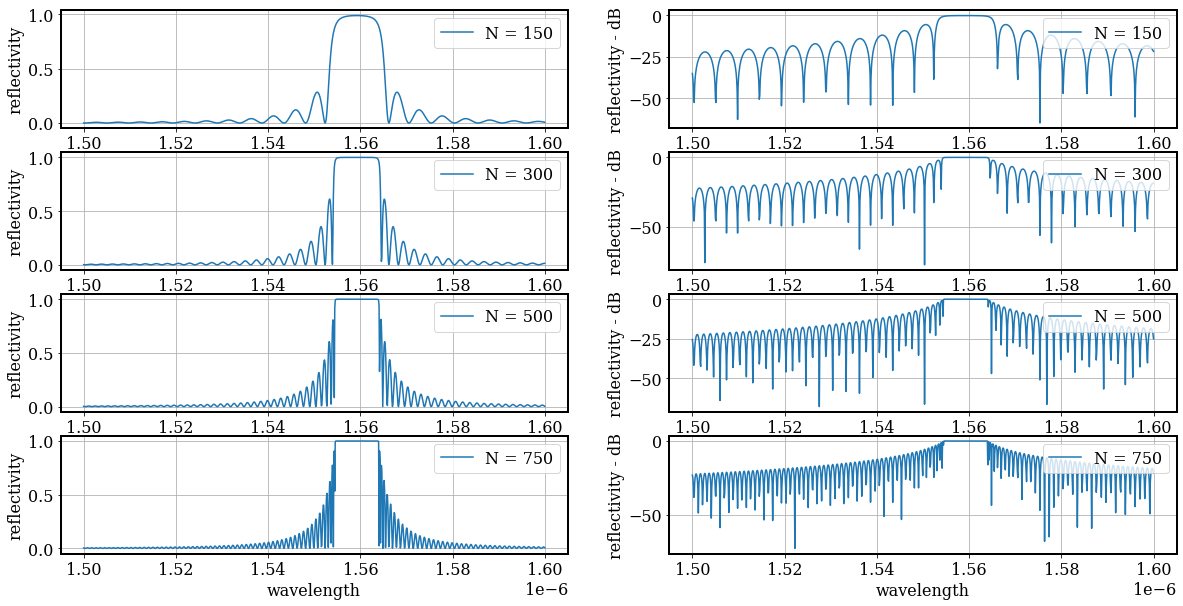

In [33]:
figure, ax = plt.subplots(4, 2, figsize = (20, 10))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
for i in range(4):
    ax[i][0].plot(wavelength, s11[i,:], label = 'N = ' + str(N[i]))
    ax[i][1].plot(wavelength, 10*np.log10(s11[i,:]), label = 'N = ' + str(N[i]))
    ax[i][0].grid(True)
    ax[i][1].grid(True)
    ax[i][0].set_xlabel('wavelength')
    ax[i][0].set_ylabel('reflectivity')
    ax[i][1].set_xlabel('wavelength')
    ax[i][1].set_ylabel('reflectivity - dB')
    ax[i][0].legend(loc = 'upper right')
    ax[i][1].legend(loc = 'upper right')

## otimizando o guia

In [79]:
w = 450e-9
delta_w = 50e-9
mode.switchtolayout()
mode.setnamed("guide1","y span", w + delta_w)
mode.setnamed("guide2","y span", w - delta_w)
mode.setnamed('guide_after','y span', w)
mode.setnamed('guide_before','y span', w)
mode.setnamed("guide1","x span",period/2)
mode.setnamed('guide2','x',period/4 + period/4)
mode.setnamed('guide2','x span',period/2)
mode.setnamed('guide_before','x min',-period/4 - 0.5e-6)
mode.setnamed('guide_before','x max',-period/4)
mode.setnamed('guide_after','x max',period/4 + period/4 + period/4 + 0.5e-6)
mode.setnamed('guide_after','x min',period/4 + period/4 + period/4)
mode.select('EME')
mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


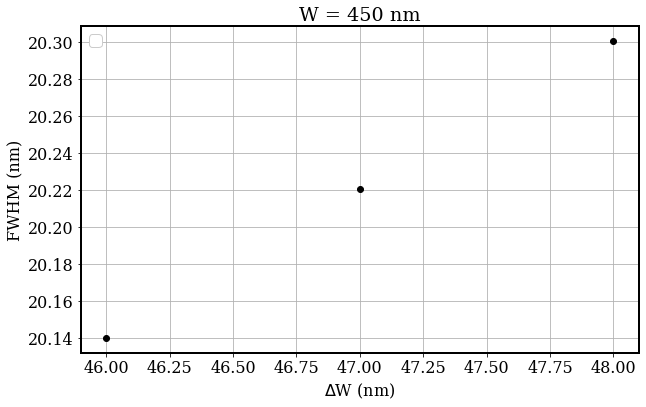

In [80]:
N = 3
corrugation_width = np.linspace(46e-9, 48e-9, N)
fwhm = np.zeros(N)
for i in range(N):
    mode.switchtolayout()
    mode.setnamed("guide1","y span",w + corrugation_width[i])
    mode.setnamed('guide2','y span',w - corrugation_width[i])
    mode.select('EME')
    mode.set("group spans", np.transpose([0.25e-6, period/2,period/2,0.25e-6]))
    mode.run()
    mode.setemeanalysis("Wavelength sweep",1)
    mode.setemeanalysis("start wavelength",1500e-9)
    mode.setemeanalysis("stop wavelength",1600e-9)
    mode.setemeanalysis("number of wavelength points",1000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    peak = find_peaks(s11, height=0.7)
    peak_pos = wavelength[peak[0]]
    mode.setemeanalysis("start wavelength",peak_pos[0][0] - 20e-9)
    mode.setemeanalysis("stop wavelength",peak_pos[0][0] + 20e-9)
    mode.setemeanalysis("number of wavelength points",1000)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    band = FWHM(wavelength, s11,500)
    fwhm[i] = band[1][0] - band[0][0]

figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
for i in range (N):
    plt.plot(corrugation_width[i]*1e9, fwhm[i]*1e9,'o', color = 'black')
#plt.plot(corrugation_width, fwhm)
#plt.plot(x*1e9, y*1e9,label = 'y = '+ str(round(a, 3)) + 'x + ' + str(round(b*1e9, 3)) + ' nm')
plt.xlabel('$\Delta$' + 'W (nm)')
plt.ylabel('FWHM (nm)')
plt.grid(True)
plt.title('W = 450 nm')
plt.legend(loc = 'upper left', framealpha = 1)

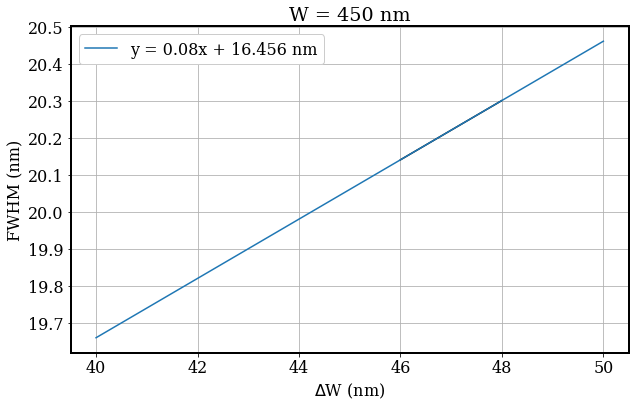

In [81]:

figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(corrugation_width*1e9, fwhm*1e9,'-', color = 'black')
a = (fwhm[2] - fwhm[0])/(corrugation_width[2] - corrugation_width[0])
b = fwhm[2] - a*corrugation_width[2]
x = np.linspace(40e-9, 50e-9, 1000)
y = a*x + b
#plt.plot(corrugation_width, fwhm)
plt.plot(x*1e9, y*1e9,label = 'y = '+ str(round(a, 3)) + 'x + ' + str(round(b*1e9, 3)) + ' nm')
#plt.plot(corrugation_width, fwhm)
#plt.plot(x*1e9, y*1e9,label = 'y = '+ str(round(a, 3)) + 'x + ' + str(round(b*1e9, 3)) + ' nm')
plt.xlabel('$\Delta$' + 'W (nm)')
plt.ylabel('FWHM (nm)')
plt.grid(True)
plt.title('W = 450 nm')
plt.legend(loc = 'upper left', framealpha = 1)

In [78]:
w = 450e-9
delta_w = 44.3e-9
mode.switchtolayout()
mode.setnamed("guide1","y span", w + delta_w)
mode.setnamed("guide2","y span", w - delta_w)
mode.setnamed('guide_after','y span', w)
mode.setnamed('guide_before','y span', w)

In [52]:
mode.switchtolayout()
number_of_iterations = 3
period_var = np.linspace(period - 5e-9, period + 5e-9, number_of_iterations)
lambda_brag = np.zeros(number_of_iterations)

for i in range(number_of_iterations):
    mode.switchtolayout()
    mode.setnamed("guide1","x span",period_var[i]/2)
    mode.setnamed('guide2','x',period_var[i]/4 + period_var[i]/4)
    mode.setnamed('guide2','x span',period_var[i]/2)
    mode.setnamed('guide_before','x min',-period_var[i]/4 - 0.5e-6)
    mode.setnamed('guide_before','x max',-period_var[i]/4)
    mode.setnamed('guide_after','x max',period_var[i]/4 + period_var[i]/4 + period_var[i]/4 + 0.5e-6)
    mode.setnamed('guide_after','x min',period_var[i]/4 + period_var[i]/4 + period_var[i]/4)
    mode.select('EME')
    mode.set("group spans", np.transpose([0.25e-6, period_var[i]/2,period_var[i]/2,0.25e-6]))
    mode.run()
    mode.setemeanalysis("start wavelength",1500e-9)
    mode.setemeanalysis("stop wavelength",1600e-9)
    mode.emesweep('wavelength sweep')
    S_parameters = mode.getemesweep("S_wavelength_sweep")
    s11= abs(S_parameters['s11']**2)
    wavelength = S_parameters['wavelength']
    peak = find_peaks(s11, height=0.8)
    peak_pos = wavelength[peak[0]]
    lambda_brag[i] = peak_pos[0][0]
    

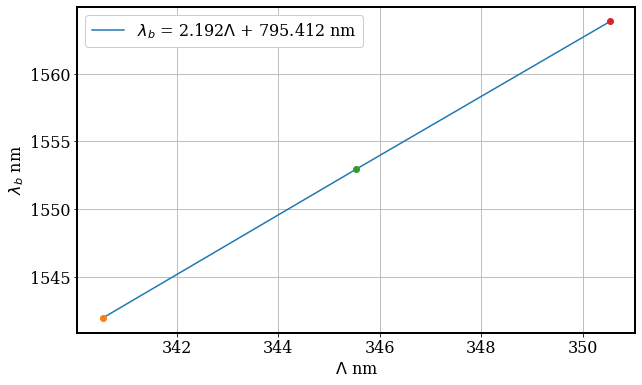

In [53]:
figure = plt.figure(figsize = (10, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
a = (lambda_brag[2] - lambda_brag[0])/(period_var[2] - period_var[0])
b = lambda_brag[0] - a*period_var[0]
plt.plot(period_var*1e9, lambda_brag*1e9, label = '$\lambda_b$ = ' + str(round(a, 3)) + '$\Lambda$' + ' + ' + str(round(b*1e9, 3)) + ' nm')
plt.plot(period_var[0]*1e9,lambda_brag[0]*1e9, 'o')
plt.plot(period_var[1]*1e9,lambda_brag[1]*1e9, 'o')
plt.plot(period_var[2]*1e9,lambda_brag[2]*1e9, 'o')
plt.xlabel('$\Lambda$' + ' nm')
plt.ylabel('$\lambda_b$' + ' nm')
plt.grid(True)
plt.legend(loc = 'upper left', framealpha = 1)

In [54]:
period_great = 348.8e-9
mode.switchtolayout()
mode.setnamed("guide1","x span",period_great/2)
mode.setnamed('guide2','x',period_great/4 + period_great/4)
mode.setnamed('guide2','x span',period_great/2)
mode.setnamed('guide_before','x min',-period_great/4 - 0.5e-6)
mode.setnamed('guide_before','x max',-period_great/4)
mode.setnamed('guide_after','x max',period_great/4 + period_great/4 + period_great/4 + 0.5e-6)
mode.setnamed('guide_after','x min',period_great/4 + period_great/4 + period_great/4)
mode.select('EME')
mode.set("group spans", np.transpose([0.25e-6, period_great/2,period_great/2,0.25e-6]))

In [67]:
number_of_wavelength_points = 1000
mode.setemeanalysis("wavelength",1)
mode.setemeanalysis("start wavelength",lambda_b - 10e-9)
mode.setemeanalysis("stop wavelength",lambda_b + 10e-9)
mode.setemeanalysis("number of wavelength points",number_of_wavelength_points)
mode.emesweep('wavelength sweep')
response = mode.getemesweep("S_wavelength_sweep")
s_response = abs(response['s11']**2)
wavelength_response = response['wavelength']
peak = find_peaks(s_response, height=0.5)
peak_pos = wavelength_response[peak[0]]
band_nulls = bandwidth(wavelength_response,s_response,499)
bandwidth_null = band_nulls[1] - band_nulls[0]

mode.setemeanalysis("wavelength",1)
mode.setemeanalysis("start wavelength",peak_pos[0][0] - 20e-9)
mode.setemeanalysis("stop wavelength",peak_pos[0][0] + 20e-9)
mode.setemeanalysis("number of wavelength points",number_of_wavelength_points)
mode.emesweep('wavelength sweep')
S_parameters = mode.getemesweep("S_wavelength_sweep")
s11= abs(S_parameters['s11']**2)
wavelength = S_parameters['wavelength']
band = FWHM(wavelength, s11,500)
fwhm = band[1] - band[0]

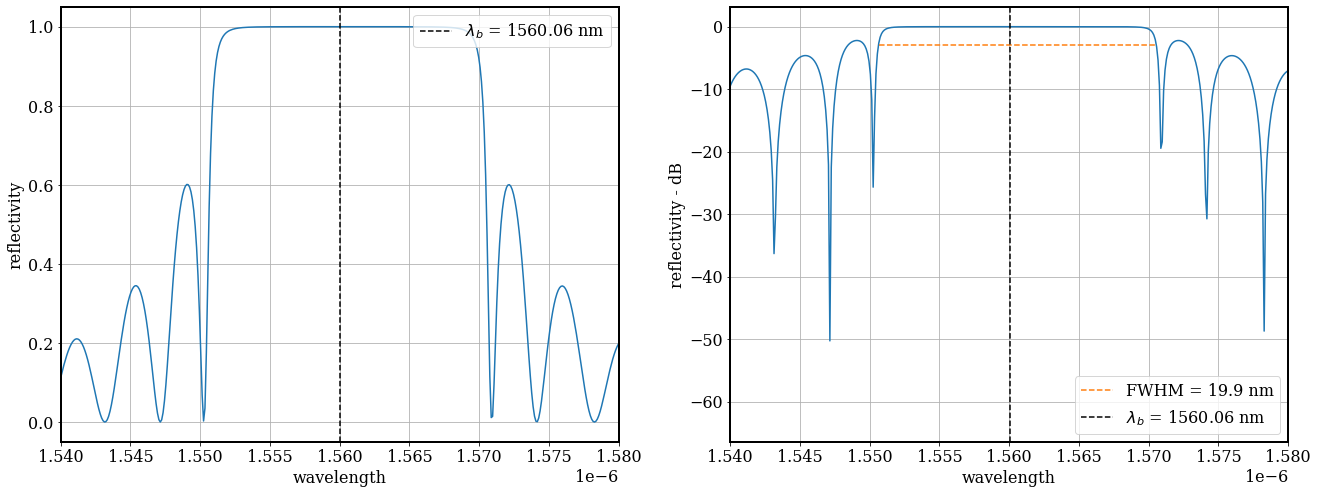

In [72]:
mode.setemeanalysis("start wavelength",1500e-9)
mode.setemeanalysis("stop wavelength",1600e-9)
mode.emesweep('wavelength sweep')
S_parameters = mode.getemesweep("S_wavelength_sweep")
s11= abs(S_parameters['s11']**2)
wavelength = S_parameters['wavelength']
peak = find_peaks(s11, height=0.85)
peak_pos = wavelength[peak[0]]

figure, ax = plt.subplots(1, 2, figsize=(22,8))

plt.rc('font', **font)
plt.rc('axes', linewidth=2)
ax[0].plot(wavelength, s11)
ax[0].axvline(x = peak_pos[0][0], linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
ax[0].set_xlim([1.54e-6, 1.58e-6])
#plt.ylim([0.07, 0.09])
ax[0].set_xlabel("wavelength")
ax[0].set_ylabel("reflectivity")
ax[0].grid(True)
ax[0].legend(loc = 'upper right')

ax[1].plot(wavelength, 10*np.log10(s11))
ax[1].plot([band[0], band[1]], [-3, -3], '--', label = "FWHM = " + str(round(fwhm[0]*1e9, 3)) + ' nm')
#ax[1].plot([band_nulls[0], band_nulls[1]], [-30, -30], '--', label = "bandwidth = " + str(round(bandwidth_null[0]*1e9, 3)) + ' nm')
ax[1].axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
ax[1].set_xlim([1.54e-6, 1.58e-6])
#plt.ylim([0.07, 0.09])
ax[1].set_xlabel("wavelength")
ax[1].set_ylabel("reflectivity - dB")
ax[1].grid(True)
ax[1].legend(loc = 'lower right')